In [33]:
import numpy as np
from matplotlib import pyplot as plt
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import geopy

In [34]:
Amatrix = lambda phi,theta,deltaT: np.array([[1,-deltaT*np.cos(phi)/np.cos(theta),0,0,0,0],
                                             [0,1,0,0,0,0],
                                            [0,0,1,0,0,0],
                                            [0,0,0,1,deltaT,0],
                                            [0,0,0,0,1,0],
                                            [0,0,0,0,0,1]])
Bmatrix = lambda phi,theta,deltaT: np.array([-deltaT*np.sin(phi)/np.cos(theta),0,0,0,0,0])
H_IMU = np.array([[0,1,-1,0,0,0],
                 [0,0,0,0,1,-1]])
H_GPS = np.array([[1,0,0,0,0,0],
                 [0,0,0,3.6,0,0]])

In [35]:
timestamp=np.genfromtxt("tmersum.log",delimiter=",",skip_header=1,usecols=(0))
timestamp*=0.001
latitude=np.genfromtxt("tmersum.log",delimiter=",",skip_header=1,usecols=(1))
longitude=np.genfromtxt("tmersum.log",delimiter=",",skip_header=1,usecols=(2))
speed=np.genfromtxt("tmersum.log",delimiter=",",skip_header=1,usecols=(3))
heading_fix2fix=np.pi/180*np.genfromtxt("tmersum.log",delimiter=",",skip_header=1,usecols=(4))
heading_vtg=np.pi/180*np.genfromtxt("tmersum.log",delimiter=",",skip_header=1,usecols=(5))
heading_imu=np.pi/180*np.genfromtxt("tmersum.log",delimiter=",",skip_header=1,usecols=(6))
yawrate=np.pi/180*np.genfromtxt("tmersum.log",delimiter=",",skip_header=1,usecols=(7))
pitchrate=np.pi/180*np.genfromtxt("tmersum.log",delimiter=",",skip_header=1,usecols=(8))
roll=np.pi/180*np.genfromtxt("tmersum.log",delimiter=",",skip_header=1,usecols=(9))
pitch=np.pi/180*np.genfromtxt("tmersum.log",delimiter=",",skip_header=1,usecols=(10))   
xacc=np.genfromtxt("tmersum.log",delimiter=",",skip_header=1,usecols=(11)) 

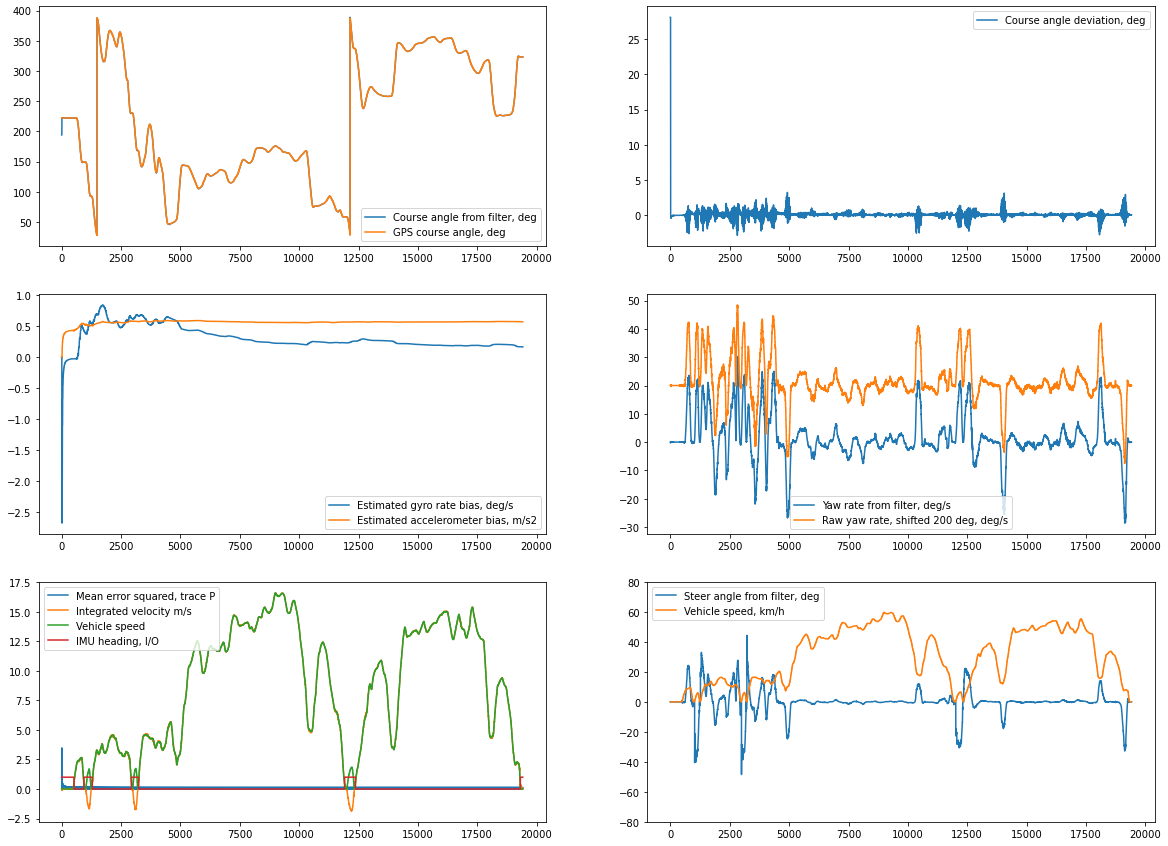

In [38]:
gpscourse = heading_fix2fix
was_speedlimit = 0.5
i_start = 1
#i_end = 20000
i_end = len(latitude)-1
#i_end = 10000
f = KalmanFilter(dim_x=6,dim_z=2)
f.x = np.array([heading_imu[i_start],yawrate[i_start],0,speed[i_start],xacc[i_start],0])
f.P *= 0.01
t_prev = 0.0
angle = []
rate = []
steer_angle_imu = []
bias = []
mu=1.0
switch = []
err_sq = []
int_vel = []
vel_bias = []
heading_shift = 0.0
imuflag = False
head_bias = 0.0
imu_on = []
for i in range(i_start,i_end):
    # Run on IMU only for heading when below speed limit
    # Match IMU and fix2fix heading when going to IMU mode
    if (f.x[3] < was_speedlimit and imuflag == False):
        head_bias = gpscourse[i]-heading_imu[i]
        imuflag = True
    if(imuflag == True):
        gpscourse[i] = heading_imu[i]+head_bias
        imu_on.append(1)
    else:
        imu_on.append(0)
    if (f.x[3] > was_speedlimit):
        imuflag = False
    #Remove 0 to 360 jumps from heading data (assume if jump is close to 2 pi it's going over)
    if gpscourse[i]-gpscourse[i-1] > 6:
        heading_shift -= 2*np.pi
    elif gpscourse[i]-gpscourse[i-1] < -6:
        heading_shift += 2*np.pi
    # Calculate deltaT
    t_cur = timestamp[i]
    #deltaT = t_cur-t_prev
    deltaT = 0.02
    t_prev = t_cur
    # Process noise from 80 deg/s2 max accel
    # Bias 0.5 deg/s
    s2yaw = 0.49
    s2acc = 10000
    f.Q = np.array([[s2yaw*deltaT**4,s2yaw*deltaT**3,0,0,0,0],
                    [s2yaw*deltaT**3,s2yaw*deltaT**2,0,0,0,0],
                    [0,0,1e-12,0,0,0],
                    [0,0,0,s2acc*deltaT**4,s2acc*deltaT**3,0],
                    [0,0,0,s2acc*deltaT**3,s2acc*deltaT**2,0],
                    [0,0,0,0,0,1e-12]])
    R_GPS=0.0001*np.array([[1,0],[0,1]])
    R_IMU=0.01*np.array([[1,0],[0,1]])
    # Define is IMU or GPS update (here for testing only IMU)
    if(np.mod(i,10)==0 and np.isnan(gpscourse[i])==False and speed[i] > was_speedlimit): 
        # GPS measurement at around 5 Hz
        HH = H_GPS
        meas = np.array([gpscourse[i]+heading_shift,np.sign(f.x[3])*speed[i]])
        f.R = R_GPS
    elif(np.mod(i,10)==0 and np.isnan(gpscourse[i])==False and speed[i] <= was_speedlimit): 
        # GPS measurement at around 5 Hz
        HH = H_GPS
        meas = np.array([gpscourse[i]+heading_shift,0])
        f.R = R_GPS
    else:
        # IMU measurement around 50 Hz
        HH = H_IMU
        meas = np.array([yawrate[i],xacc[i]])
        f.R = R_IMU
    # Construct matrices based on current attitude
    AA = Amatrix(roll[i],pitch[i],deltaT)
    BB = Bmatrix(roll[i],pitch[i],deltaT)
    # Calculate predict & update step for Kalman filter
    f.F = AA
    f.B = BB
    f.H = HH
    f.predict(u=np.array(pitchrate[i]))
    f.update(meas)
    # Write current values for plotting
    angle.append((f.x[0]-heading_shift)*180/np.pi)
    rate.append(((f.x[1]-f.x[2])*np.cos(roll[i])/np.cos(pitch[i])+np.sin(roll[i])/np.cos(pitch[i])*pitchrate[i])*180/np.pi)
    # Set zero angle to avoid dividing by zero
    if (speed[i] > was_speedlimit):
        steer_angle_imu.append(180.0/np.pi*np.arctan(np.pi/180.0*2.76*rate[-1]/(f.x[3])))
    else:
        steer_angle_imu.append(0.0)
    # Rate gyro bias
    bias.append(f.x[2]*180/np.pi)
    # Error
    err_sq.append(np.trace(f.P))
    # Integrated velocity
    int_vel.append(f.x[3])
    # Acceleration bias
    vel_bias.append(f.x[5])
fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6)) = plt.subplots(3, 2, figsize=(20,15))
ax1.plot(angle,label='Course angle from filter, deg')
ax1.plot(gpscourse[i_start:i_end]*180/np.pi,label="GPS course angle, deg")
ax1.legend()
ax2.plot(gpscourse[i_start:i_end]*180/np.pi-angle,label='Course angle deviation, deg')
ax2.legend()
ax3.plot(bias,label='Estimated gyro rate bias, deg/s')
ax3.plot(vel_bias,label='Estimated accelerometer bias, m/s2')
ax3.legend()
ax4.plot(rate,label='Yaw rate from filter, deg/s')
ax4.plot(yawrate[i_start:i_end]*180/np.pi+20,label='Raw yaw rate, shifted 200 deg, deg/s')
ax4.legend()
#ax5.plot(err_sq,label='Mean error squared, trace P')
ax5.plot(int_vel,label='Integrated velocity m/s')
ax5.plot(speed[i_start:i_end]/3.6,label='Vehicle speed')
ax5.plot(imu_on,label="IMU heading, I/O")
ax5.legend()
#ax6.plot(switch,label='1 = switching rule active')
#ax6.plot(yawrate[i_start:i_end]*180/np.pi-rate,label='Raw yaw rate minus filtered, deg/s')
#ax6.plot(timestamp_aog,-steer_angle,label="Steer angle from WAS, deg")
#ax6.plot(timestamp[i_start:i_end],rate,label="Rate from filter, deg")
ax6.plot(steer_angle_imu,label="Steer angle from filter, deg")
ax6.plot(speed[i_start:i_end],label="Vehicle speed, km/h")
ax6.set_ylim([-80, 80])
ax6.legend()

In [32]:
plt.rcParams["figure.figsize"]=20,15
plt.plot(timestamp_aog,-steer_angle,label="Steer angle from WAS, deg")
plt.plot(timestamp[i_start:i_end],rate,label="Rate from filter, deg")
plt.show()

NameError: name 'timestamp_aog' is not defined